**Trump tweets...**

Every morning I check twitter, first thing, while still in bed, to see if a presidential executive order removed one of the freedoms American citizens have till today enjoyed. The fact that this would come through twitter is quite depressing. The value of eloquence is dead, clearly. But tweets are by their 140 character nature suited to be analyzed, so I figured I'd look form something interesting, some pattern, some reason and order in this madness. I found nothing. From a data science point of  view the pile of words uttered through twitter by DT is boring as hell.
Honestly people. We just need to not to pay attention to it. Really, the important, the terrifying things will happen in a deafening twitter silence and the stage we are offering to his bitching and moaning, cause largely this is what it is, continues to make him feel important. He is not. He is just the right man in the right place and time, or better, the very very wrong man at the worse possible place and time. 

# Importing Packages. 
Other than usual python utils I will need twython (https://twython.readthedocs.io/) to scrap twitter, and ntlk Natural Language Toolkit (http://www.nltk.org/)

In [1]:
from __future__ import print_function
import time 
import re
import string
import pandas as pd
import operator
import pylab as pl
import datetime as dt
import json
import scipy
from scipy import stats


#more unusal packages
import twython
from twython import Twython
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import twitter_samples
import nltk.corpus as corpus
from nltk.corpus import twitter_samples
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#import pylab_histep as ph
# I am storing my Twython credential in tweetAPI.py. 
# The dictionary needs to contain the keys: 'consumer_key', 'consumer_secret', 'access_token', 'access_secret'
import tweetAPI

%pylab inline
pl.rcParams.update({'font.size': 20, 
                    'axes.facecolor': "#FFFCF8"})

#if  nltk corpus is not downloaded yet run the two cells:
#nltk.corpus.twitter_samples?
#nltk.download() 


Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
print("Software versions:")
print("twython:", twython.__version__)
print("nltk:", nltk.__version__)

Software versions:
twython: 3.4.0
nltk: 3.2.1


## define some functions and utilities


In [3]:
# smoothing function. Originally I got it from stackoverflow, but its been a long time and I do not have a ref for it
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order + 1)
    half_window = (window_size - 1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range]
                for k in range(-half_window, half_window + 1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs(y[1:half_window + 1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window - 1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')

## utility functions for sentiment analysis

In [4]:
# functions for sentiment analysis
def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
        all_words.extend(words)
    return all_words


def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features, wordlist


def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

# Get the tweets

## connecting to twitter and setting the parameter of what I want to get: 
as many tweets as possible from DT: @realDonaldTrump

In [5]:
twitter = Twython(
    tweetAPI.tweetAPI['consumer_key'], tweetAPI.tweetAPI['consumer_secret'],
    tweetAPI.tweetAPI['access_token'], tweetAPI.tweetAPI['access_secret'])

user = "realDonaldTrump"
user_timeline = twitter.get_user_timeline(screen_name=user, count=1)

## getting the tweets 
we have to get around the limit of the twitter API: 3200 tweets altogether is enough, it will give us over a yer of data, but there is a limit of 200 for each API call
The tweet dictionary contains an 'id' field, which is a unique sequential number. I get the most recent tweet id, and from there I set up 16 calls of 200 tweets each with a 5 minutes break in between, but, here is the important part, each call starting at the last tweet id I already have (otherwise i get the same 200 tweets 16 times). 

In my data I actually have a few more than 3200 tweets, cause I worked on this a bit two weekends ago and a bit last weekend, so I end up with 3259 tweets (it was a busy week!). If you instead run the following frozen cells you get (after a couple of hours) 3200 (actually 3199)
 

In [ ]:
lis = [user_timeline[0]['id']] ## this is the latest starting tweet id
rdttweets = []

for i in [0]:
    user_timeline = twitter.get_user_timeline(screen_name=user,
    count=200, include_retweets=False, max_id=lis[-1])
    for tweet in user_timeline:
        rdttweets.append(tweet) ## append the tweet
        lis.append(tweet['id']) ## append tweet id's

In [ ]:
MULTI = True
if MULTI:
    for i in range(1, 16): ## iterate through all tweets
## tweet extract method with the last list item as the max_id
        user_timeline = twitter.get_user_timeline(screen_name=user,
        count=200, include_retweets=False, max_id=lis[-1])
        
        for tweet in user_timeline:
            rdttweets.append(tweet) ## append the tweet
            lis.append(tweet['id']) ## append tweet id's
        time.sleep(300) ## 5 minute rest between api calls


In [ ]:
# after getting the tweets I save them in a pickle file so i can restart this notebook and reread them in
with open('rdttweets.json', 'w') as fp:
    json.dump(rdttweets, fp)


In [6]:
json_data = open("rdttweets.json").read()

rdttweets = json.loads(json_data)
print(len(rdttweets))

3250


## extract relevant tweet info

In [7]:
## print out the fields in the tweet dictionary 
print("tweet dictionary keys")
rdttweets[0].keys()

tweet dictionary keys


[u'contributors',
 u'truncated',
 u'text',
 u'is_quote_status',
 u'in_reply_to_status_id',
 u'id',
 u'favorite_count',
 u'source',
 u'retweeted',
 u'coordinates',
 u'entities',
 u'in_reply_to_screen_name',
 u'in_reply_to_user_id',
 u'retweet_count',
 u'id_str',
 u'favorited',
 u'user',
 u'geo',
 u'in_reply_to_user_id_str',
 u'lang',
 u'created_at',
 u'in_reply_to_status_id_str',
 u'place']

In [8]:
texttweets = np.array([tt['text'] for tt in rdttweets])  # the tweet
retweets = np.array(
    [tt['retweet_count'] for tt in rdttweets])  # the number of retweets
liketweets = np.array(
    [tt['favorite_count'] for tt in rdttweets])  # the number of likes

tweetstime = [tt['created_at'] for tt in rdttweets]  # the tweet timestamp

In [9]:
#convert the tweet timestamps to datetime
print("tweet time format:", tweetstime[0])
ttimes = np.array([
    dt.datetime.strptime(tts.replace('+', '00'), '%a %b %d %H:%M:%S %f %Y')
    for tts in tweetstime
])

tweet time format: Fri Feb 10 13:35:50 +0000 2017


In [10]:
print("Earliest tweet in dataset: ", min(ttimes))
print("Most recent tweet in dataset: ", max(ttimes))

Earliest tweet in dataset:  2016-03-15 13:24:01
Most recent tweet in dataset:  2017-02-10 13:35:50


# Visualization and exploratory analysis of tweet likes and retweets

## Time series of likes and retweets

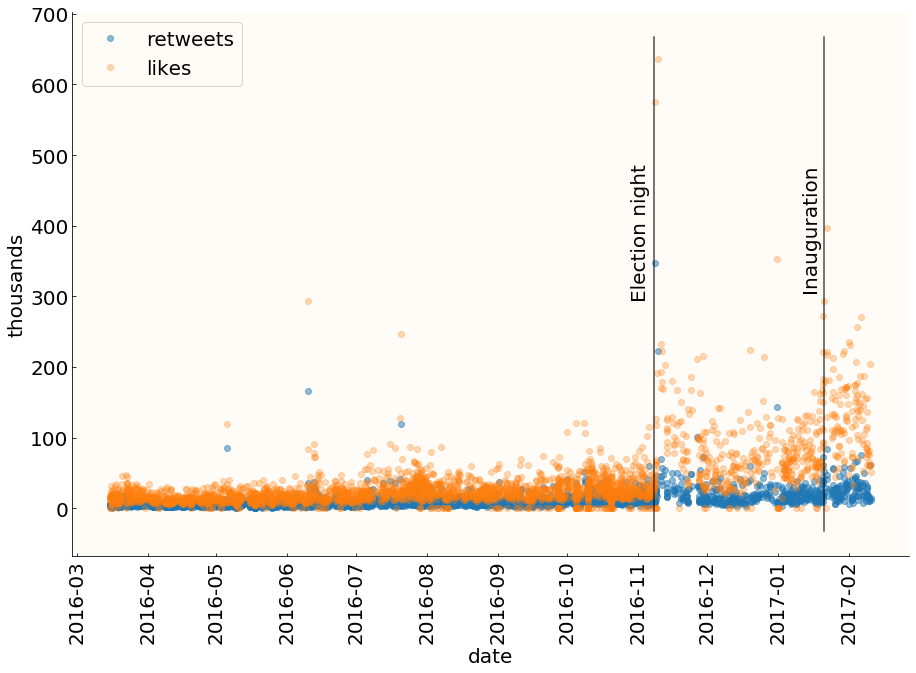

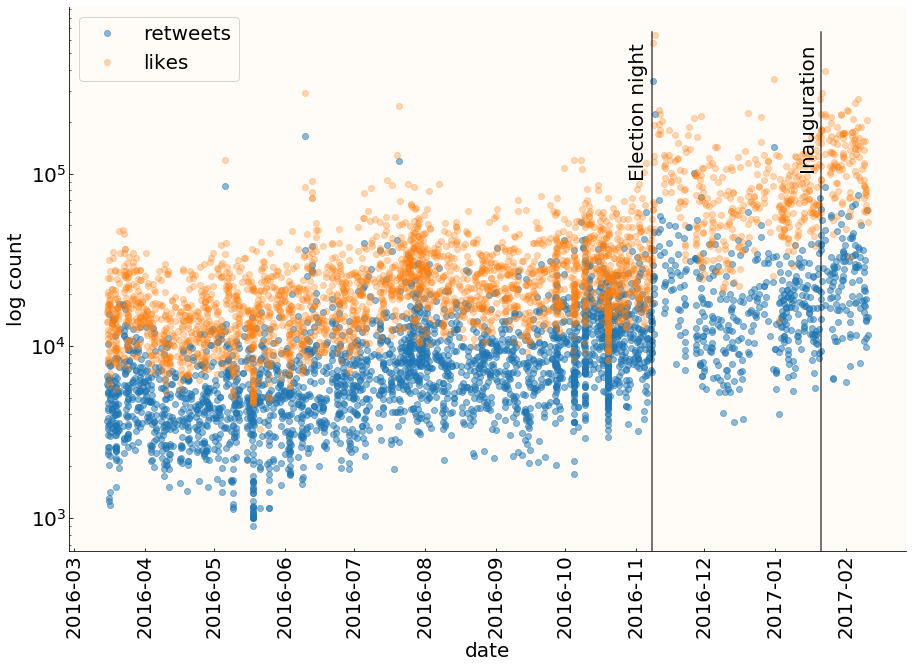

In [11]:
ax = pl.figure(figsize=(15, 10)).add_subplot(111)
ax.plot(ttimes, retweets * 1e-3, 'o', alpha=0.5, label="retweets")
ax.plot(ttimes, liketweets * 1e-3, 'o', alpha=0.3, label="likes")

ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
electionNight = dt.datetime.strptime('2016,11,08', '%Y,%m,%d')
inauguration = dt.datetime.strptime('2017,01,21', '%Y,%m,%d')
ax.plot([electionNight, electionNight], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    electionNight + dt.timedelta(days=-10),
    ymax * 0.7,
    "Election night",
    rotation=90)
ax.plot([inauguration, inauguration], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    inauguration + dt.timedelta(days=-10),
    ymax * 0.7,
    "Inauguration",
    rotation=90)
ax.set_xlabel("date")
ax.set_ylabel("thousands")
pl.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xticks = pl.xticks(rotation='vertical')

ax = pl.figure(figsize=(15, 10)).add_subplot(111)
ax.plot(ttimes, retweets, 'o', alpha=0.5, label="retweets")
ax.plot(ttimes, liketweets, 'o', alpha=0.3, label="likes")
len(ttimes)
ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
ax.plot([electionNight, electionNight], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    electionNight + dt.timedelta(days=-10),
    ymax * 0.7,
    "Election night",
    rotation=90)
ax.plot([inauguration, inauguration], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    inauguration + dt.timedelta(days=-10),
    ymax * 0.7,
    "Inauguration",
    rotation=90)
ax.set_xlabel("date")
ax.set_ylabel("log count")
pl.legend()
ax.set_yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xticks = pl.xticks(rotation='vertical')

### Fig 1: the timeline of popularity, in likes and retweets (orange and blue respectively). The critical dates of the election and inauguration are marked by vertical lines, with obvious corresponding spikes in retweets and likes. In the top panel they are shown in natural, and in the middle in log scale to enhance the data features. 

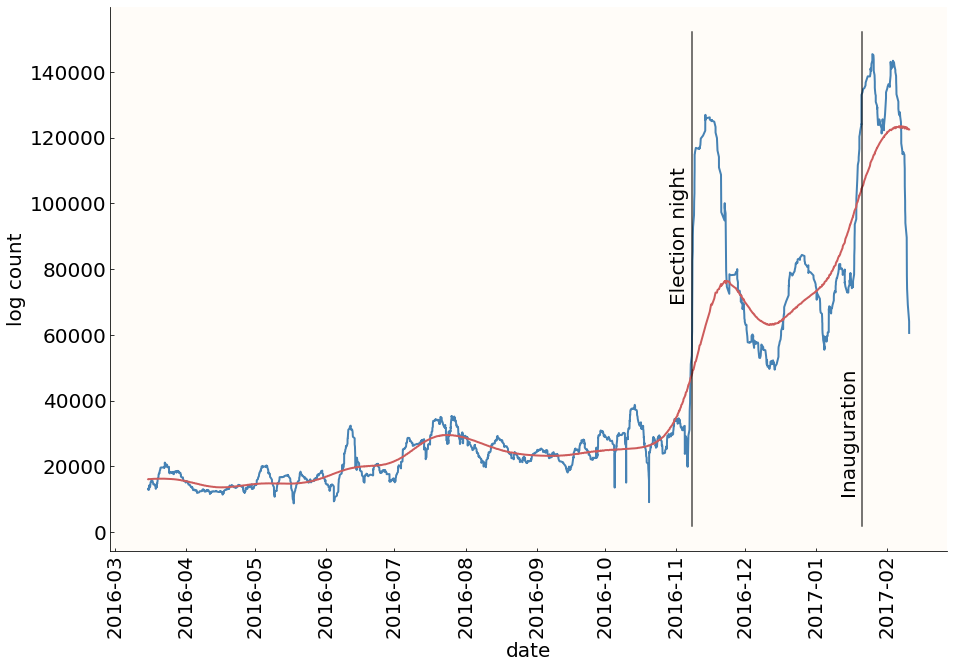

In [12]:
ax = pl.figure(figsize=(15, 10)).add_subplot(111)
ax.plot(
    ttimes, savitzky_golay(liketweets, 99, 2), 'k-', lw=2,
    color='SteelBlue')  # window size 51, polynomial order 3
ax.plot(
    ttimes, [
        np.average(
            liketweets,
            weights=[
                np.exp(-(days.days)**2 * (0.5 / 7)**2)
                for days in (ttimes[ti] - ttimes)
            ]) for ti in range(len(ttimes))
    ],
    lw=2,
    color='IndianRed')
# window size 51, polynomial order 3
ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
ax.plot([electionNight, electionNight], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    electionNight + dt.timedelta(days=-10),
    ymax * 0.7,
    "Election night",
    rotation=90)
ax.plot([inauguration, inauguration], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    inauguration + dt.timedelta(days=-10),
    ymax * 0.3,
    "Inauguration",
    rotation=90)
ax.set_xlabel("date")
ax.set_ylabel("log count")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xticks = pl.xticks(rotation='vertical')

### Fig 2. The bottom panel shows the likes smoothed with a Gaussian filter over time (red) smoothed with a kernel of a week (Gaussian standard deviation) and with a Savitzky-Golay filter over 99 tweets. Sadly this shows a steady increase in popularity.

There is a significant number of posts with 0 likes. This seems unlikely (pun intended). So let's take a look at those:

In [13]:
likerank = liketweets.argsort()  # indices sorted by likes
rtrank = retweets.argsort()  # indices sorted by retweets (will use later)
print("Number of tweets with 0 likes:", sum(liketweets == 0))
texttweets[liketweets == 0][:10]
# looks like they are all retweets: verify that
print("Number of **original** tweets with 0 likes :", sum(liketweets == 0) -
      sum([tt.startswith("RT") for tt in texttweets[liketweets == 0]]))

Number of tweets with 0 likes: 168
Number of **original** tweets with 0 likes : 0


Alas, all of the original DT tweets have likes. 

In [14]:
originalTweets = ~np.array([tt.startswith("RT") for tt in texttweets])
print("Number of original tweets in the dataset:", sum(originalTweets))

Number of original tweets in the dataset: 3082


From here on, unless stated otherwise, I am working only with original tweets

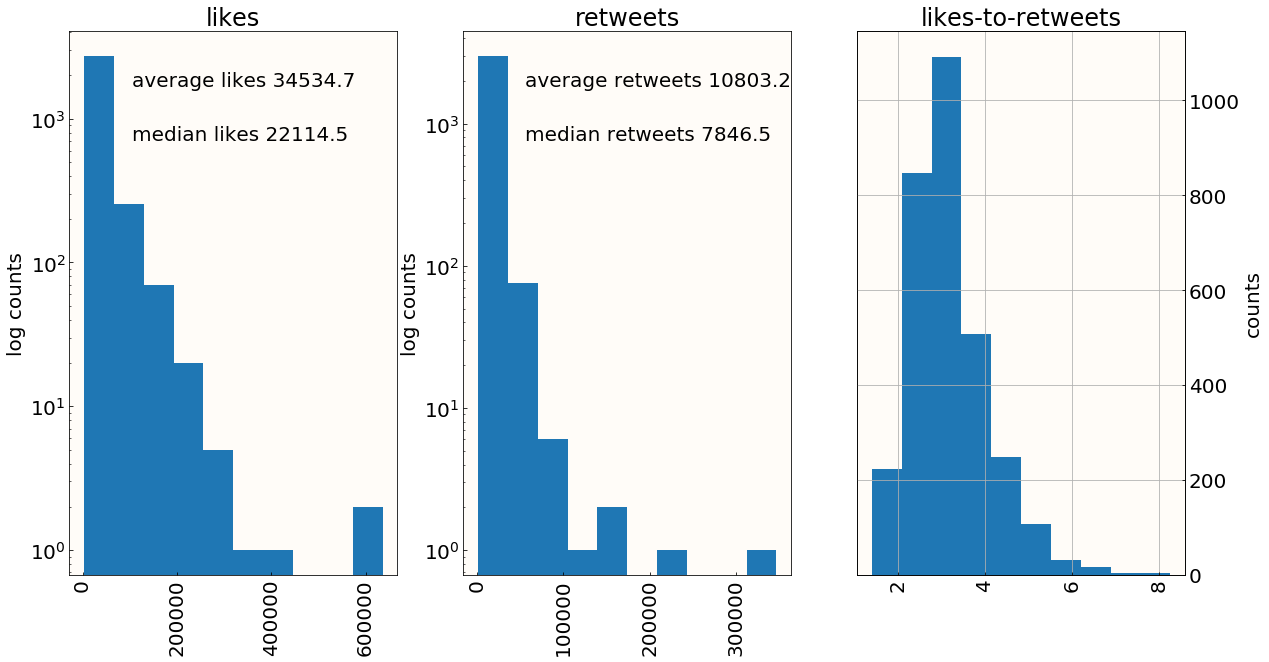

In [15]:
fig = pl.figure(figsize=(20, 10))
ax = fig.add_subplot(131)
pl.hist(liketweets[originalTweets])
pl.text(
    0.19,
    0.9,
    "average likes %.1f" % liketweets[originalTweets].mean(),
    transform=ax.transAxes)
pl.text(
    0.19,
    0.8,
    "median likes %.1f" % median(liketweets[originalTweets]),
    transform=ax.transAxes)
pl.xticks(rotation='vertical')
ax.set_yscale('log')
ax.set_title("likes")
ax.set_ylabel("log counts")

ax = fig.add_subplot(132)
pl.hist(retweets[originalTweets])
pl.text(
    0.19,
    0.9,
    "average retweets %.1f" % retweets[originalTweets].mean(),
    transform=ax.transAxes)
pl.text(
    0.19,
    0.8,
    "median retweets %.1f" % median(retweets[originalTweets]),
    transform=ax.transAxes)
pl.xticks(rotation='vertical')
ax.set_yscale('log')
ax.set_title("retweets")
ax.set_ylabel("log counts")

ax = fig.add_subplot(133)
pl.hist(liketweets[originalTweets].astype(float) / retweets[originalTweets])
pl.xticks(rotation='vertical')
pl.grid(True)
ax2 = ax.twinx()
ax.set_yticks([])
ax2.set_ylabel("counts")
ax2.set_ylim(ax.get_ylim())
pl.grid(True)
title = ax.set_title("likes-to-retweets")

### Fig 3: distribution of like counts, retweet counts (in log space to enhance visibility), and of like-to-retweet ratios. The like-to-retweets ratio peaks around 3, and have a long tail. So let's investigate the retweets further.


## Who retweets?
Liking a tweet has a pretty unequivocal meaning, but retweets can be done in support as well as do denounce a tweet statement. So retweets measure the influence of a post, while likes measure its approval. If DT's most noticeable tweets also his best liked one the retweets and likes should be strongly correlated. A simple Pearson's test will do for these simultaneous time series. 

In [16]:
print("retweet-likes Pearson's correlation")
scipy.stats.pearsonr(retweets, liketweets)

retweet-likes Pearson's correlation


(0.87542086491743087, 0.0)

The positive correlation and the high R squared, indicate that in fact retweets go hand in hand with likes. There is certainly a fraction of these that are retweeted   in order to denounce and express dissent. If that was a large fraction, it would show significant polarization: DT supporters like his most controvertial tweets. Studying this would require a sentiment analysis of the retweets and comments, which is too much for this one-notebook project. But I will do some sentiment analysis below.

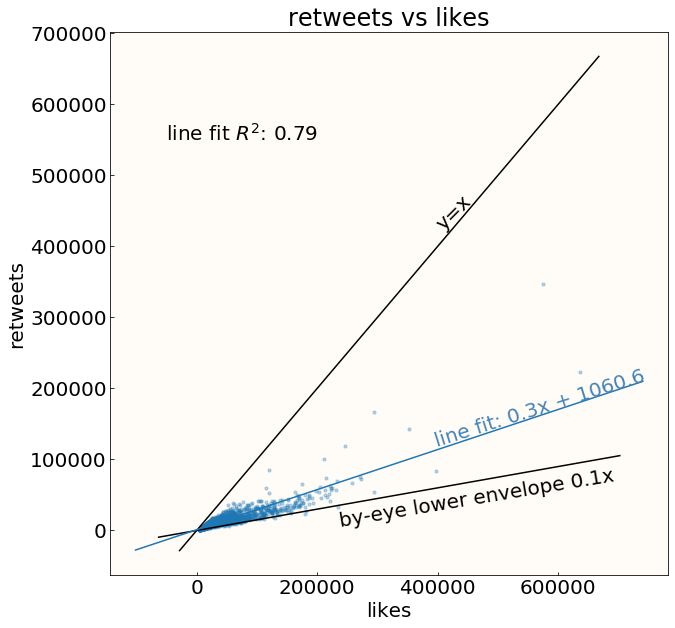

In [17]:
ax = pl.figure(figsize=(10, 10)).add_subplot(111)
ax.scatter(
    liketweets[liketweets > 0], retweets[liketweets > 0], s=10, alpha=0.3)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]],
        [ax.get_xlim()[0], ax.get_xlim()[1]], 'k')
#ax.set_ylim(ax.get_xlim()[0], ax.get_xlim()[1])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], .15 * np.array(
    [ax.get_xlim()[0], ax.get_xlim()[1]]), 'k')

linefit = np.polyfit(
    liketweets[originalTweets],
    retweets[originalTweets],
    1,
    rcond=None,
    full=False,
    w=None,
    cov=False)
xspace = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 10)
model = np.poly1d(linefit)
ax.plot(xspace, model(xspace))
ax.text(ax.get_xlim()[1] * 0.5, ax.get_ylim()[1] * 0.65, "y=x", rotation=45)
ax.text(
    ax.get_xlim()[1] * 0.5,
    ax.get_ylim()[1] * 0.3,
    "line fit: %.1fx + %.1f" % (linefit[0], linefit[1]),
    rotation=np.arctan(linefit[0]) / np.pi * 200,
    color="SteelBlue")
ax.text(
    ax.get_xlim()[1] * 0.3,
    ax.get_ylim()[1] * 0.1,
    "by-eye lower envelope %.1fx" % (0.15),
    rotation=np.arctan(0.15) / np.pi * 200)
ax.set_ylabel("retweets")
ax.set_xlabel("likes")

# calculate R^2
den = np.sum(retweets[originalTweets]) / len(
    retweets[originalTweets])  # or sum(y)/len(y)
ssreg = np.sum((model(liketweets[originalTweets]) - den)**
               2)  # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((retweets[originalTweets] - den)**
               2)  # or sum([ (yi - ybar)**2 for yi in y])
r2 = ssreg / sstot
ax.set_title("retweets vs likes")
text = ax.text(0.1, 0.8, r"line fit $R^2$: %.2f" % r2, transform=ax.transAxes)

### Fig 4: modeling popularity: the retweets are modelled fairly well by a simple like fit to the likes, indicating that either the people retweeting are  supporters, or that the critiques are impressed by the same tweets that supporters note and approve. Without a sentiment analysis of the retweets and of the profiles of retweeters and likers, and with the obvious effects of feedback in social media popularity (tweets going "viral"), it is impossible to disentangle these effects

## DT's top (and bottom) 10

In [18]:
print("DT's most liked tweet:\n\t",
      texttweets[np.where(liketweets == liketweets.max())[0]][0])
print("It has %d likes" % liketweets.max())

DT's most liked tweet:
	 Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never before
It has 635854 likes


I'll go back to this tweet when I work on the sentiment analysis

In [19]:
print("DT's least liked tweet:\n\t", texttweets[originalTweets][np.where(
    liketweets[originalTweets] == liketweets[originalTweets].min())[0]][0])
print("It has %d likes" % liketweets[originalTweets].min())

DT's least liked tweet:
	 @montgomeriefdn  Colin, great to have you at Trump Turnberry. So proud of you and your GREAT playing! You made winning MAJORS look easy!
It has 3287 likes


This is amusing: I know nothing about golf, so I had no idea who @montgomeriefdn (Colin Montgomery) is, and it turns out it is unclear whether this tweet is trolling, or honest http://www.golfchannel.com/news/grill-room/trump-congratulates-monty-winning-majors/. either way, not very interesting apparently (as the opposite of a golf fan I must agree. As someone exausted of the abuse of the word "win" I also agree)

In [20]:
print("DT's most retweeted tweet:\n\t",
      texttweets[np.where(retweets == retweets.max())[0]][0])
print("It has %d retweeted" % retweets.max())

DT's most retweeted tweet:
	 TODAY WE MAKE AMERICA GREAT AGAIN!
It has 347302 retweeted


surprise surprise...

In [21]:
print("DT's most retweeted tweet:\n\t",
      texttweets[np.where(retweets == retweets.min())[0]][0])
print("It has %d retweeted" % retweets.min())

DT's most retweeted tweet:
	 "@jrector34: @realDonaldTrump Amazing job"
It has 901 retweeted


This is sadly hilarious: it is DT citing a random tweet in his favor from an account without picture, started on April 2015, which has 82 followers and some 750 tweets, ALL OF THEM, as far as I can say, in support of DT. So clearly an account generated to support DT (by DT???) which gets retweeted by DT to show how the people support DT, and then retweeted by 901 people (simulation theory anyone??). Actually I think its a twitter-bot that they created to boost his approval. It's fully expected that those would exist, and this account has no other explanation. But the fact that he retweets it!!?!

In [22]:
print("likes        date           tweet")
for tt, ttime, like in zip(texttweets[likerank][-10:], ttimes[likerank][-10:],
                           liketweets[likerank][-10:]):
    print(like, ttime, tt, "\n")

likes        date           tweet
246669 2016-07-20 15:36:06 The media is spending more time doing a forensic analysis of Melania's speech than the FBI spent on Hillary's emails. 

257043 2017-02-04 14:26:10 MAKE AMERICA GREAT AGAIN! 

270307 2017-02-06 03:36:54 What an amazing comeback and win by the Patriots. Tom Brady, Bob Kraft and Coach B are total winners. Wow! 

272789 2017-01-20 12:31:53 It all begins today! I will see you at 11:00 A.M. for the swearing-in. THE MOVEMENT CONTINUES - THE WORK BEGINS! 

293556 2017-01-21 04:56:15 THANK YOU for another wonderful evening in Washington, D.C. TOGETHER, we will MAKE AMERICA GREAT AGAIN🇺🇸 https://t.co/V3aoj9RUh4 

294142 2016-06-09 20:40:32 How long did it take your staff of 823 people to think that up--and where are your 33,000 emails that you deleted? https://t.co/gECLNtQizQ 

352747 2016-12-31 13:17:21 Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. L

In [23]:
print("likes        date           tweet")
for tt, ttime, rt in zip(texttweets[rtrank][-10:], ttimes[rtrank][-10:],
                         liketweets[rtrank][-10:]):
    print(rt, ttime, tt, "\n")

likes        date           tweet
215009 2016-11-29 11:55:13 Nobody should be allowed to burn the American flag - if they do, there must be consequences - perhaps loss of citizenship or year in jail! 

270307 2017-02-06 03:36:54 What an amazing comeback and win by the Patriots. Tom Brady, Bob Kraft and Coach B are total winners. Wow! 

396616 2017-01-22 14:23:17 Peaceful protests are a hallmark of our democracy. Even if I don't always agree, I recognize the rights of people to express their views. 

119624 2016-05-05 18:57:30 Happy #CincoDeMayo! The best taco bowls are made in Trump Tower Grill. I love Hispanics! https://t.co/ufoTeQd8yA https://t.co/k01Mc6CuDI 

211044 2016-11-26 13:08:11 Fidel Castro is dead! 

246669 2016-07-20 15:36:06 The media is spending more time doing a forensic analysis of Melania's speech than the FBI spent on Hillary's emails. 

352747 2016-12-31 13:17:21 Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they 

something interesting: two tweets that make the top 10 retweets  but not the top 10 likes are the CindoDeMayo tweet and the death of Fidel Castro. My guess is that the first is sarcastic retweets to point out the idiocy of the tweet, and that the Fidel Castro is showing that some people are actually getting their news from DT.

# Sentiment analysis

Sentiment analysis performed with nltk. This is a vanilla sentiment analysis, I will use a NaiveBayes classifier with the standard Stanford training set. I am going to do very minimal text prep, which is definitely a weak point of this analysis, but this is just for fun after all.

## Dataset preparation

In [24]:
postweets = twitter_samples.docs(fileids='positive_tweets.json')
negtweets = twitter_samples.docs(fileids='negative_tweets.json')

this data prepping is really vanilla. TODO:  remove handles before stripping punctuation...

In [25]:
# prepping trainig set
table = string.maketrans("", "")
table
tweets = []
for words in postweets:
    words_filtered = [
        e.lower() for e in re.split('\W+', words['text'])
        if len(e) >= 3 and '@' not in e and 'http' not in e
    ]
    tweets.append((words_filtered, "positive"))
for words in negtweets:
    words_filtered = [
        e.lower() for e in re.split('\W+', words['text'])
        if len(e) >= 3 and '@' not in e and 'http' not in e
    ]
    tweets.append((words_filtered, "negative"))

training_set = postweets[-100:] + negtweets[-100:]
postweets = postweets[:-100]
negtweets = negtweets[:-100]

In [26]:
print("most common words")
word_features, wordlist = get_word_features(get_words_in_tweets(tweets))
sorted(wordlist.items(), key=operator.itemgetter(1))[:-10:-1]

most common words


[(u'you', 2394),
 (u'the', 2005),
 (u'and', 1425),
 (u'for', 1177),
 (u'have', 765),
 (u'that', 724),
 (u'this', 622),
 (u'but', 619),
 (u'can', 565)]

## Prepping DT's dataset

In [27]:
print("DT's tweet words")
histweets = []
[[histweets.append(e.lower().replace('x15', ''))
    for e in re.split('\W+', rdttweets[i]['text'])
    if len(e) >= 3 and '@' not in e and 'http' not in e
] for i in range(len(rdttweets))]
histweets[:10]

DT's tweet words


[u'the',
 u'failing',
 u'nytimes',
 u'does',
 u'major',
 u'fake',
 u'news',
 u'china',
 u'story',
 u'saying']

In [28]:
# extracting features from DT's tweets
ef = extract_features(histweets)

In [29]:
training_set = nltk.classify.apply_features(extract_features, tweets)

## Run the classifier:  
to run it unfreeze the two cells below. I saved the result, cause this is very time consuming

In [ ]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [ ]:
save_classifier = open("naivebayes.pickle", "wb")
pickle.dump(classifier, save_classifier)
save_classifier.close()

In [30]:
classifier = pickle.load(open("naivebayes.pickle", "rb"))

In [31]:
print(classifier.show_most_informative_features(30))

Most Informative Features
           contains(bam) = True           positi : negati =     29.7 : 1.0
           contains(sad) = True           negati : positi =     26.8 : 1.0
           contains(x15) = True           negati : positi =     23.7 : 1.0
     contains(community) = True           positi : negati =     21.0 : 1.0
       contains(arrived) = True           positi : negati =     18.7 : 1.0
           contains(ugh) = True           negati : positi =     17.7 : 1.0
          contains(glad) = True           positi : negati =     17.4 : 1.0
     contains(goodnight) = True           positi : negati =     16.3 : 1.0
         contains(loves) = True           positi : negati =     14.4 : 1.0
 contains(unfortunately) = True           negati : positi =     14.3 : 1.0
         contains(shame) = True           negati : positi =     13.0 : 1.0
 contains(opportunities) = True           positi : negati =     13.0 : 1.0
     contains(followers) = True           positi : negati =     13.0 : 1.0

Here are a few amusing thing: the most predictive words in the president of the US tweets are "bam" and "sad". Also highly ranking: ugh, shame, justinbieber... we live in a strange strange world



In [ ]:
# we work with a probabilisitc classification: 
# each tweet has an associated probability of being positive and being negative, 
# summing to 1
probsentiment = np.array([classifier.prob_classify(extract_features(rdt['text'].split())) 
                          for rdt in rdttweets])
save_prob = open("probsentiment.pkl", "wb")
pickle.dump(probsentiment, save_prob)
save_prob.close()


In [32]:
probsentiment = pickle.load(open("probsentiment.pkl", "rb"))
probsentiment = np.array(probsentiment)

In [33]:
positiveprob = np.array([(ps.prob('positive')) for ps in probsentiment])

## Visualizing DT's sentiments (assuming that he has "sentiments")

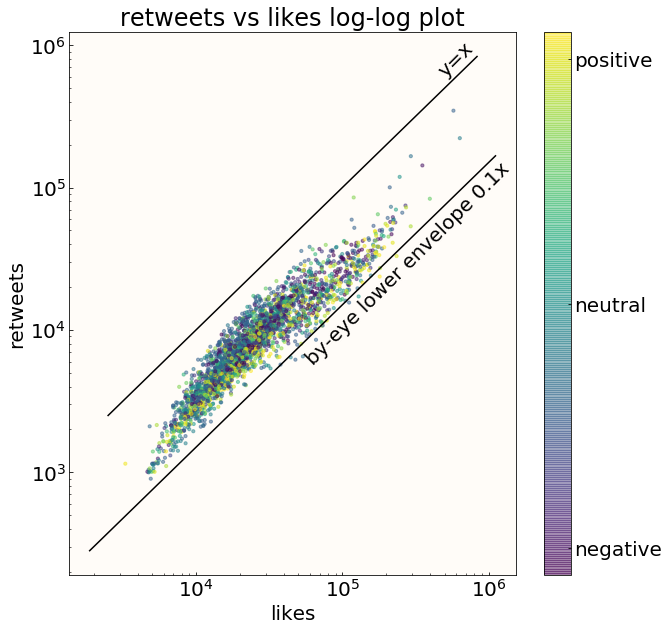

In [34]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')
cax = ax.scatter(
    liketweets[originalTweets],
    retweets[originalTweets],
    s=10,
    c=positiveprob[originalTweets],
    alpha=0.5)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]],
        [ax.get_xlim()[0], ax.get_xlim()[1]], 'k')
#ax.set_ylim(ax.get_xlim()[0], ax.get_xlim()[1])

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]],
        .15 * np.array([ax.get_xlim()[0], ax.get_xlim()[1]]), 'k')
ax.set_ylabel("retweets")
ax.set_xlabel("likes")

ax.set_title("retweets vs likes log-log plot")
cbar = fig.colorbar(cax, ticks=[0.05, 0.5, 0.95])
labels = cbar.ax.set_yticklabels(['negative', 'neutral', 'positive'])
ax.text(ax.get_xlim()[1] * 0.28, ax.get_ylim()[1] * 0.7, "y=x", rotation=45)
text = ax.text(
    ax.get_xlim()[1] * 0.035,
    ax.get_ylim()[1] * 0.1,
    "by-eye lower envelope %.1fx" % (0.15),
    rotation=np.arctan(0.85) / np.pi * 200)

### Fig 5: This color segregation shows something: the positive tweets are to the right. Negative feeling tweets have more retweets per like than positive ones. This may be the effect of "dissent retweets".

In [35]:
print("likes factor for negative tweets: %.2f" % (
    (sum(liketweets[positiveprob < 0.5]) - sum(liketweets[positiveprob >= 0.5])
     ).astype(float) / sum(liketweets[positiveprob < 0.5])))
print("retweet factor for negative tweets: %.2f" % (
    (sum(retweets[positiveprob < 0.5]) - sum(retweets[positiveprob >= 0.5])
     ).astype(float) / sum(retweets[positiveprob < 0.5])))

likes factor for negative tweets: 0.39
retweet factor for negative tweets: 0.44


The like and retweet factors (the normalized difference of likes/retweets for positive and negative sentiment tweets) is higher for retweets than for likes.

In [36]:
sid = SentimentIntensityAnalyzer()
print('likes, probability that it is positive')
for i in range(5):
    print(liketweets[likerank[::-1][i]], ",",
          probsentiment[likerank[::-1][i]].prob('positive'),
          classifier.classify(
              extract_features(rdttweets[likerank[::-1][i]]['text'].split())))
    ss = sid.polarity_scores(rdttweets[likerank[::-1][i]]['text'])
    print('{0}: {1}, '.format('compound', ss['compound']), end='')
    print("\t", rdttweets[likerank[::-1][i]]['text'], "\n")

likes, probability that it is positive
635854 , 0.421189986576 negative
compound: 0.4926, 	 Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never before 

575212 , 0.306308094706 negative
compound: 0.6588, 	 TODAY WE MAKE AMERICA GREAT AGAIN! 

396616 , 0.751831823738 positive
compound: 0.049, 	 Peaceful protests are a hallmark of our democracy. Even if I don't always agree, I recognize the rights of people to express their views. 

352747 , 0.0489999645344 negative
compound: -0.4911, 	 Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. Love! 

294142 , 0.366736931026 negative
compound: 0.0, 	 How long did it take your staff of 823 people to think that up--and where are your 33,000 emails that you deleted? https://t.co/gECLNtQizQ 



The 5 most liked tweets are mostly negative, but here is where it gets interesting: they are "designed" (Happy New year, MAGA) to be superficially positive, but there are a lot of negative connotation words: forgotten, never, enemies, badly... so ironically the happy new year tweet ends up with a strongly negative score, although with a significant 'polarity', i.e. ambivalence in the choice of words.

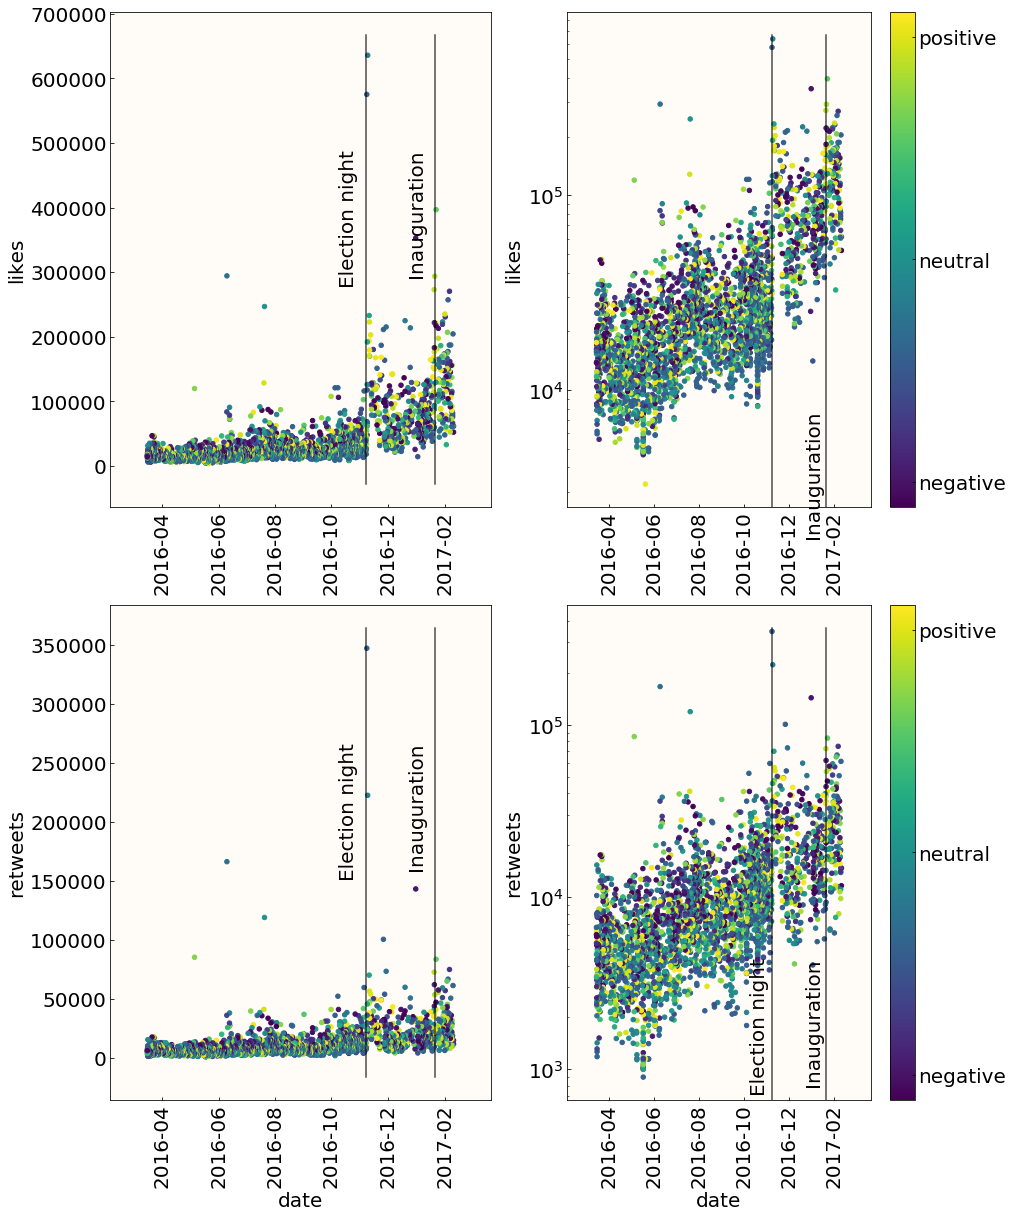

In [37]:
fig = pl.figure(figsize=(15, 20))
ax = fig.add_subplot(221)
cax = pl.scatter(
    np.array(ttimes[originalTweets]),
    liketweets[originalTweets],
    cmap='viridis',
    #color=[(ps.prob('negative'),0.2,ps.prob('positive')) for ps in probsentiment], 
    c=positiveprob[originalTweets],
    s=20,
    alpha=1)
cbar.ax.set_yticklabels(['negative', 'neutral', 'positive'])
ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
ax.plot([electionNight, electionNight], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    electionNight + dt.timedelta(days=-30),
    ymax * 0.7,
    "Election night",
    rotation=90)
ax.plot([inauguration, inauguration], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    inauguration + dt.timedelta(days=-30),
    ymax * 0.7,
    "Inauguration",
    rotation=90)
pl.xticks(rotation='vertical')
pl.ylabel('likes')

ax = fig.add_subplot(223)
cax = ax.scatter(
    np.array(ttimes[originalTweets]),
    retweets[originalTweets],
    cmap='viridis',
    #color=[(ps.prob('negative'),0.2,ps.prob('positive')) for ps in probsentiment], 
    c=positiveprob[originalTweets],
    s=20,
    alpha=1)
ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
ax.plot([electionNight, electionNight], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    electionNight + dt.timedelta(days=-30),
    ymax * 0.7,
    "Election night",
    rotation=90)
ax.plot([inauguration, inauguration], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    inauguration + dt.timedelta(days=-30),
    ymax * 0.7,
    "Inauguration",
    rotation=90)
pl.xticks(rotation='vertical')
pl.xlabel('date')
pl.ylabel('retweets')
ax = fig.add_subplot(222)
cax = pl.scatter(
    ttimes[originalTweets],
    liketweets[originalTweets],
    cmap='viridis',
    #color=[(ps.prob('negative'),0.2,ps.prob('positive')) for ps in probsentiment], 
    c=positiveprob[originalTweets],
    s=20,
    alpha=1)
cbar = fig.colorbar(cax, ticks=[0.05, 0.5, 0.95])
cbar.ax.set_yticklabels(['negative', 'neutral', 'positive'])
ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
ax.plot([electionNight, electionNight], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    electionNight + dt.timedelta(days=-30),
    ymax / 1001,
    "Election night",
    rotation=90)
ax.plot([inauguration, inauguration], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    inauguration + dt.timedelta(days=-30),
    ymax / 100,
    "Inauguration",
    rotation=90)
pl.xticks(rotation='vertical')
pl.ylabel('likes')
ax.set_yscale('log')

ax = fig.add_subplot(224)
cax = ax.scatter(
    ttimes[originalTweets],
    retweets[originalTweets],
    cmap='viridis',
    #color=[(ps.prob('negative'),0.2,ps.prob('positive')) for ps in probsentiment], 
    c=positiveprob[originalTweets],
    s=20,
    alpha=1)
cbar = fig.colorbar(cax, ticks=[0.05, 0.5, 0.95])
cbar.ax.set_yticklabels(['negative', 'neutral', 'positive'])
ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
ax.plot([electionNight, electionNight], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    electionNight + dt.timedelta(days=-30),
    ymax / 100,
    "Election night",
    rotation=90)
ax.plot([inauguration, inauguration], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    inauguration + dt.timedelta(days=-30),
    ymax / 100,
    "Inauguration",
    rotation=90)
pl.xticks(rotation='vertical')
pl.xlabel('date')
pl.ylabel('retweets')
yscale = ax.set_yscale('log')

### Fig 6: Same as figure 1 and 2, time series of likes (top) and retweets (bottom) in natural (left) and log (right) space. Again the color segregation: positive tweets are liked more, negative tweets are retweeted more.

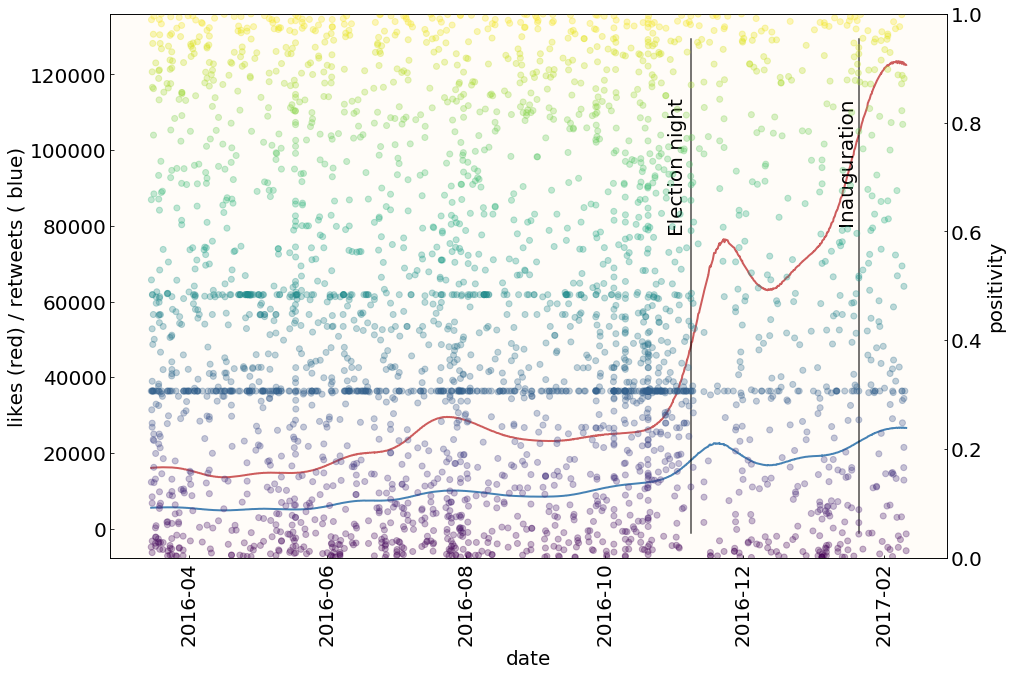

In [38]:
ax = pl.figure(figsize=(15, 10)).add_subplot(111)
#pl.plot(ttimes[originalTweets], retweets[originalTweets], '.')
#pl.plot(ttimes[originalTweets], liketweets[originalTweets], '.', alpha=0.5)
ax.plot(
    ttimes, [
        np.average(
            liketweets,
            weights=[
                np.exp(-(days.days)**2 * (0.5 / 7)**2)
                for days in (ttimes[ti] - ttimes)
            ]) for ti in range(len(ttimes))
    ],
    lw=2,
    color='IndianRed')

ax.plot(
    ttimes, [
        np.average(
            retweets,
            weights=[
                np.exp(-(days.days)**2 * (0.5 / 7)**2)
                for days in (ttimes[ti] - ttimes)
            ]) for ti in range(len(ttimes))
    ],
    lw=2,
    color='SteelBlue')

ax.set_xlabel("date")
ax.set_ylabel("likes (red) / retweets ( blue)")
ymin, ymax = pl.ylim()[0], pl.ylim()[1]
ax.plot([electionNight, electionNight], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    electionNight + dt.timedelta(days=-10),
    ymax * 0.85,
    "Election night",
    rotation=90)
ax.plot([inauguration, inauguration], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    inauguration + dt.timedelta(days=-10),
    ymax * 0.85,
    "Inauguration",
    rotation=90)
pl.xticks(rotation='vertical')
ax2 = ax.twinx()
ax2.set_ylabel("positivity")
pl.scatter(
    ttimes[originalTweets],
    positiveprob[originalTweets],
    alpha=0.3,
    cmap='viridis',
    c=positiveprob[originalTweets])
lims = ax2.set_ylim(0, 1)

### Fig 7: This plot is definitely designed as an exploratory visualization, which normally I would take out of a final version of a notebook, but I am leaving it in cause it gave me a couple of ideas. The scatter plot represents each tweet, where the sentiment is measured as "positivity":  the probability that the tweet's content is positive. The positivity of the tweet is represented twice (bad thing to do) by the color (positivity increasing from purple to yellow) and the height (higher more positive).  After election night two things jump to my eye. The tweet rate obviously decreases, and it seems that the tweets become more polarized (are more concentrated at high and low positivity values). Next I will explore these two effects. There are also two unusual features, a concentration of sentiment at ~0.35 and 0.45 probability of positive: this is probably indicative of a bias in the sentiment analysis but I am not strict about this, so I am not going to investigate it further now; it will just be added to my TODO list.

## Trends: let's bin the time series and see if trends appear more obviously. 

In [39]:
likeseries = pd.Series(
    index=ttimes[originalTweets], data=liketweets[originalTweets])
rtseries = pd.Series(
    index=ttimes[originalTweets], data=retweets[originalTweets])
positiveseries = pd.Series(
    index=ttimes[originalTweets], data=positiveprob[originalTweets])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: .resample() is now a deferred operation


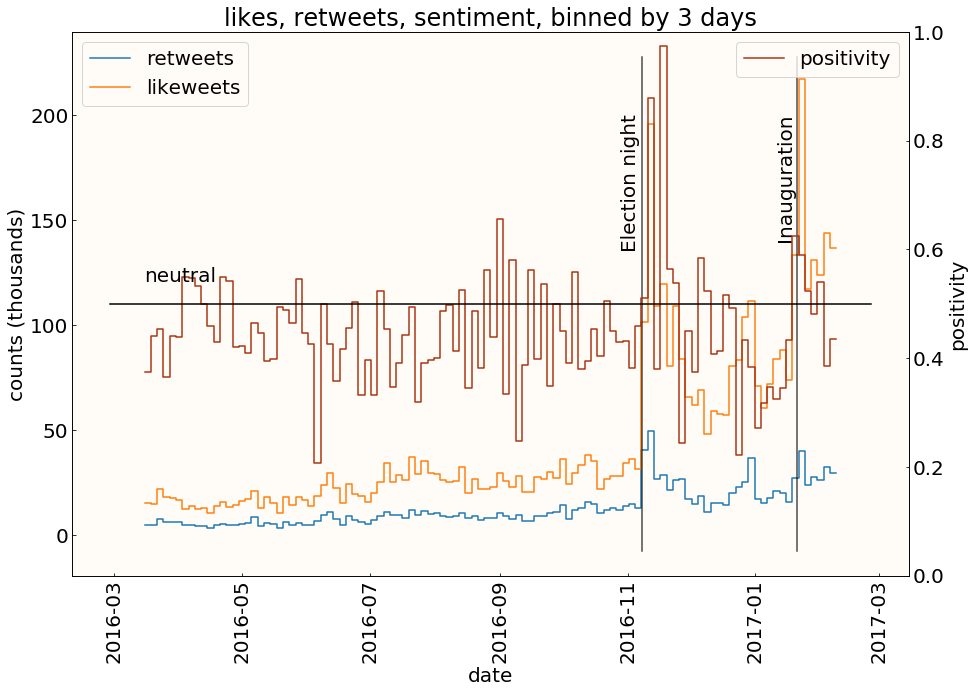

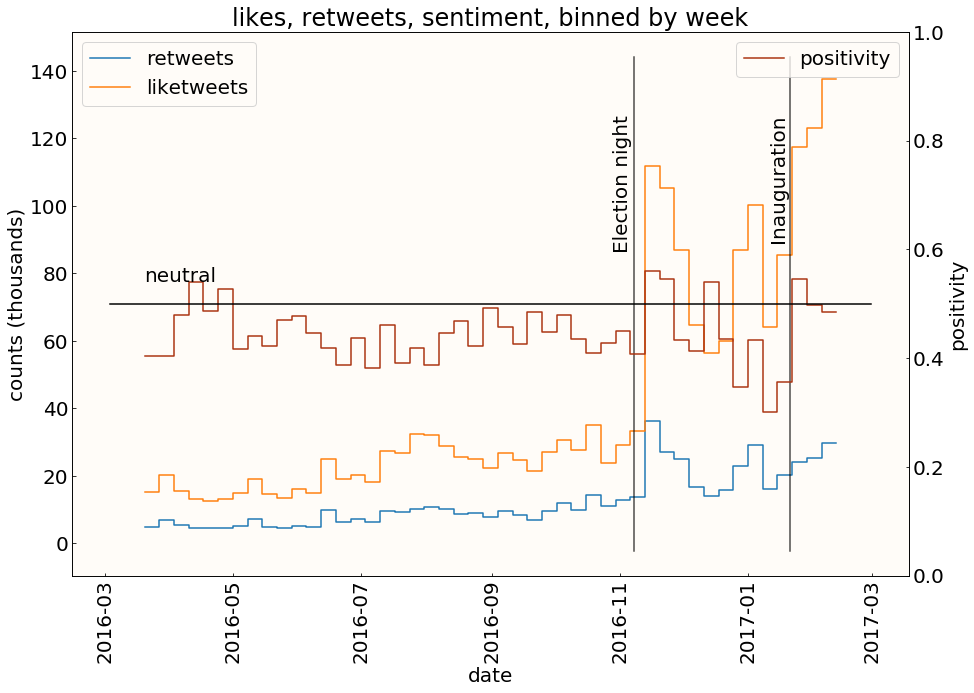

In [40]:
ax = pl.figure(figsize=(15, 10)).add_subplot(111)
x, y = np.ravel(
    zip(rtseries.resample('3D').index[:-1], rtseries.resample('3D').index[
        1:])), np.ravel(
            zip(
                rtseries.resample('3D').values[:-1],
                rtseries.resample('3D').values[:-1]))
ax.plot(x, y * 1e-3, label="retweets")
x, y = np.ravel(
    zip(
        likeseries.resample('3D').index[:-1],
        likeseries.resample('3D').index[1:])), np.ravel(
            zip(
                likeseries.resample('3D').values[:-1],
                likeseries.resample('3D').values[:-1]))
ax.plot(x, y * 1e-3, label="likeweets")
ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]

ax.plot([electionNight, electionNight], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    electionNight + dt.timedelta(days=-10),
    ymax * 0.85,
    "Election night",
    rotation=90)
ax.plot([inauguration, inauguration], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    inauguration + dt.timedelta(days=-10),
    ymax * 0.85,
    "Inauguration",
    rotation=90)
pl.xticks(rotation='vertical')
x, y = np.ravel(
    zip(
        positiveseries.resample('3D').index[:-1],
        positiveseries.resample('3D').index[1:])), np.ravel(
            zip(
                positiveseries.resample('3D').values[:-1],
                positiveseries.resample('3D').values[:-1]))
pl.legend()

#ph.myhisteps(positiveseries.resample('').index, positiveseries.resample('W').values)
ax2 = ax.twinx()
ax.set_title("likes, retweets, sentiment, binned by 3 days")
pl.xticks(rotation='vertical')
ax.set_xlabel("date")
ax.set_ylabel("counts (thousands)")
ax2.plot(x, y, '#aa3311', label="positivity")
ax2.set_ylim(0, 1)
ax2.set_ylabel("positivity")

pl.legend()
pl.plot(ax.get_xlim(), [0.5, 0.5], 'k-')
ax2.text(x[0], 0.54, "neutral")

ax = pl.figure(figsize=(15, 10)).add_subplot(111)
x = np.ravel(
    zip(rtseries.resample('W').index[:-1], rtseries.resample('W').index[1:]))
y = np.ravel(
    zip(
        rtseries.resample('W').values[:-1], rtseries.resample('W').values[:
                                                                          -1]))
ax.plot(x, y * 1e-3, label="retweets")
x = np.ravel(
    zip(
        likeseries.resample('W').index[:-1], likeseries.resample('W').index[
            1:]))
y = np.ravel(
    zip(
        likeseries.resample('W').values[:-1],
        likeseries.resample('W').values[:-1]))
ax.plot(x, y * 1e-3, label="liketweets")
pl.legend()
ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
ax.plot([electionNight, electionNight], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    electionNight + dt.timedelta(days=-10),
    ymax * 0.85,
    "Election night",
    rotation=90)
ax.plot([inauguration, inauguration], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    inauguration + dt.timedelta(days=-10),
    ymax * 0.85,
    "Inauguration",
    rotation=90)
x = np.ravel(
    zip(
        positiveseries.resample('W').index[:-1],
        positiveseries.resample('W').index[1:]))
y = np.ravel(
    zip(
        positiveseries.resample('W').values[:-1],
        positiveseries.resample('W').values[:-1]))

pl.xticks(rotation='vertical')

ax2 = ax.twinx()

ax.set_xlabel("date")
ax.set_ylabel("counts (thousands)")
ax2.plot(x, y, '#aa3311', label="positivity")
ax2.set_ylabel("positivity")

ax2.set_ylim(0, 1)
ax2.text(x[0], 0.54, "neutral")
pl.legend()
pl.plot(ax.get_xlim(), [0.5, 0.5], 'k-')
pl.xticks(rotation='vertical')
title = ax.set_title("likes, retweets, sentiment, binned by week")

### Fig 8: I binned like counts, retweets, and sentiment (calculating the average sentiment) over 3 days windows, and 1-week windows. The binning shows a few trends: a disheartening steady increase in likes (orange, and retweets, blue), with an up-step in coincidence of election night. To me this is surprising: I would have thought his followers were more engaged and active during the campaign, but he actually gained tweeter approval steadily after election night. The average sentiment does not change much, and it is slightly negative over the entire time period of this exploration. The positivity spikes significantly right after both election night and inauguration, but also slightly decreased with time in the period between the elections and the nomination, surprisingly (to me). 

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


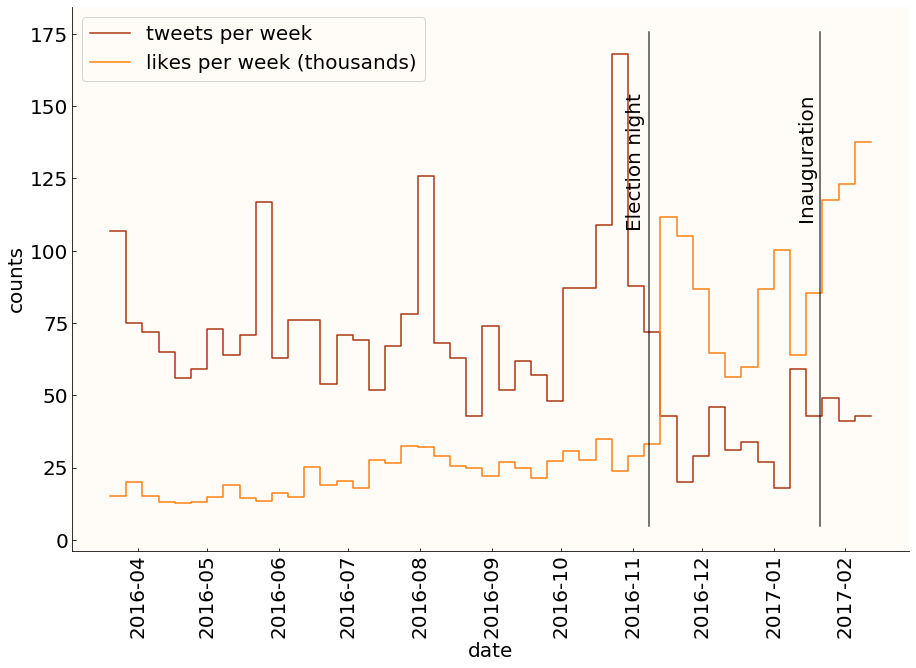

In [41]:
ax = pl.figure(figsize=(15, 10)).add_subplot(111)
## grebbing colors for retweets and likes 
for i, c in enumerate(ax._get_lines.prop_cycler):
    if i == 0:
        rcolor = c['color']
    if i == 1:
        lcolor = c['color']
        break
xy = likeseries.groupby(pd.TimeGrouper('w')).count()
x, y = np.ravel(zip(xy.index[:-1], xy.index[1:])), np.ravel(
    zip(xy.values[:-1], xy.values[:-1]))
ax.plot(x, y, label="tweets per week", color="#aa3311")
xl = np.ravel(
    zip(
        likeseries.resample('W').index[:-1], likeseries.resample('W').index[
            1:]))
yl = np.ravel(
    zip(
        likeseries.resample('W').values[:-1],
        likeseries.resample('W').values[:-1]))
ax.plot(xl, yl * 1e-3, label="likes per week (thousands)", color=lcolor)
ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
ax.plot([electionNight, electionNight], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    electionNight + dt.timedelta(days=-10),
    ymax * 0.85,
    "Election night",
    rotation=90)
ax.plot([inauguration, inauguration], [ymin, ymax], 'k-', alpha=0.7)
ax.text(
    inauguration + dt.timedelta(days=-10),
    ymax * 0.85,
    "Inauguration",
    rotation=90)
pl.legend()
ax.set_xlabel("date")
ax.set_ylabel("counts")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
xt = pl.xticks(rotation='vertical')

### Fig 9: Binned time series of tweet likes and tweet counts by week. There was a uptake on tweets before the elections, and a significant drop the week before the election and thereafter (remember they sequestered his account right before the election because of his erratic tweet behavior - the uptake that starts on 2016-10). It sure feels like he is still twitting a lot though...

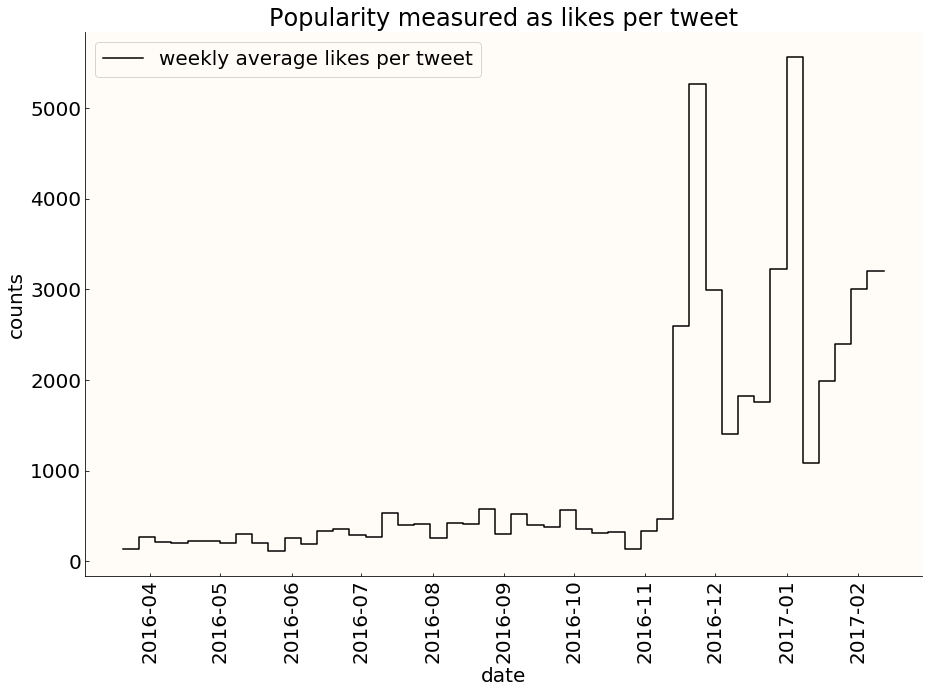

In [42]:
ax = pl.figure(figsize=(15, 10)).add_subplot(111)
ax.plot(x, yl / y, label="weekly average likes per tweet", color="k")
pl.legend()
pl.title("Popularity measured as likes per tweet")
ax.set_xlabel("date")
ax.set_ylabel("counts")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
xt = pl.xticks(rotation='vertical')

### Fig 10: And here are the normalized likes per week, which show his 10-fold increase in popularity: per tweet he gets an average of 2000 likes after election night, compared to an average of ~200 before. 

## Sentiment trends

looking at the plot above and Figure 7 it seems post election tweets are more polarizing

probability that sentiment distribution changed (p-value really) 1.75


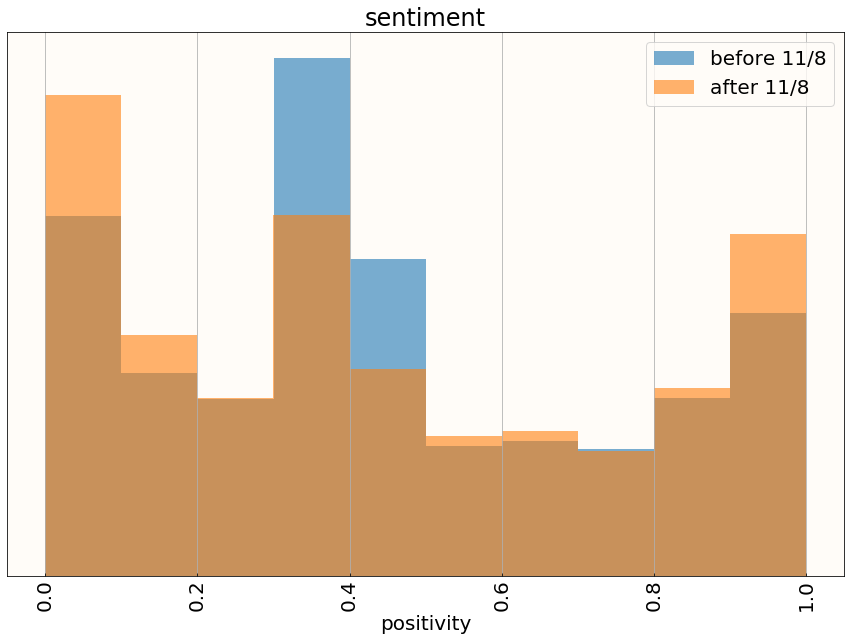

In [43]:
fig = pl.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.hist(
    positiveprob[originalTweets * (ttimes < electionNight)],
    alpha=0.6,
    label="before 11/8",
    normed=1)
ax.hist(
    positiveprob[originalTweets * (ttimes >= electionNight)],
    alpha=0.6,
    label="after 11/8",
    normed=1)

pl.xticks(rotation='vertical')
pl.grid(True)
ax.set_yticks([])
pl.grid(True)
title = ax.set_title("sentiment")
pl.legend()
pl.xlabel("positivity")
print("probability that sentiment distribution changed (p-value really) %.2f" %
      (100 * scipy.stats.ks_2samp(positiveprob[originalTweets *
                                               (ttimes < electionNight)],
                                  positiveprob[originalTweets *
                                               (ttimes >= electionNight)])[1]))

### Fig. 11: The tweets have gotten more polarized after the election. This may have to do with the decrease in tweet frequency: DT is twitting less, so he is foregoing tweets about nuisances that would have a more neutral content. A simple KS test shows the distributions are significantly different (p-value of the positive probability being drawn from the same distribution is <2%). 

# The time of day effects

DT became infamous for twitting at the wee hours of the night, revealing erratic sleep patterns and impulsive behaviors, one may say, common to oh so many internet trolls. Here I look at the effect of the time of the day on his tweets. 

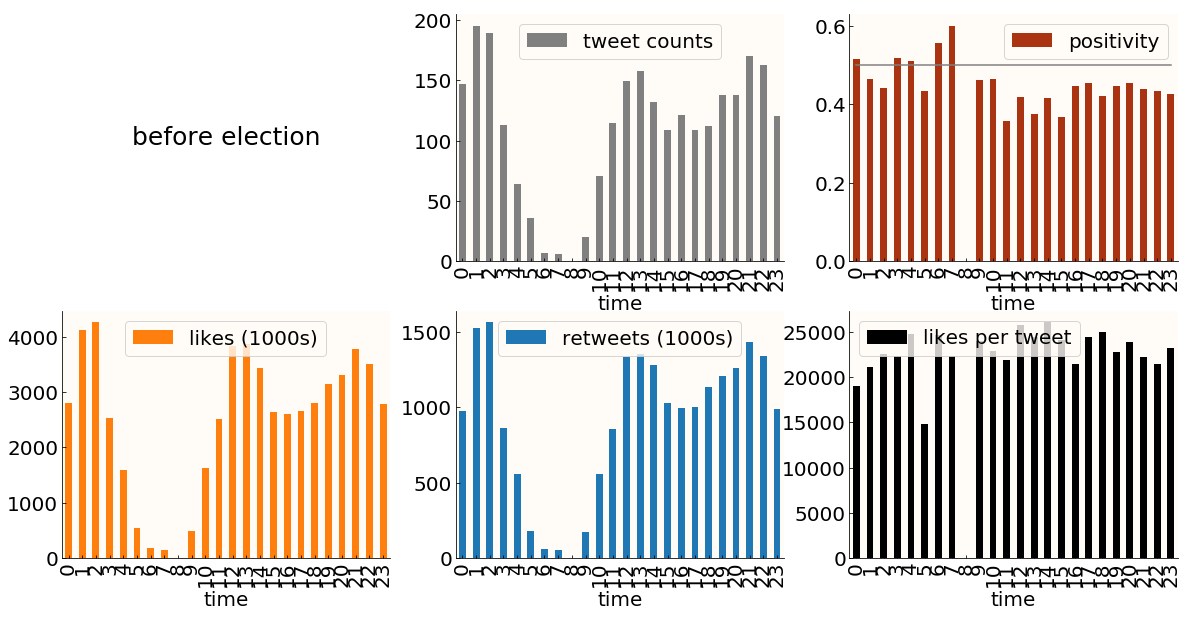

In [44]:
fig = pl.figure(figsize=(20, 10))
ax = fig.add_subplot(232)

df = pd.DataFrame({
    'time':
    ttimes[originalTweets * (ttimes < electionNight)],
    'likes':
    liketweets[originalTweets * (ttimes < electionNight)],
    'rts':
    retweets[originalTweets * (ttimes < electionNight)],
    'prob':
    positiveprob[originalTweets * (ttimes < electionNight)]
})
df['UnixStamp'] = df['time'].apply(lambda d: time.mktime(d.timetuple()))

df1 = pd.DataFrame({})
df1['time'] = pd.date_range("0:00", "23:59", freq="60min")
df = df.merge(df1, how='outer')

(df['likes'] * 1e-3).groupby(
    [df['time'].apply(lambda x: x.hour)]).count().plot(
        kind='bar', label="tweet counts", color='gray')
pl.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax0 = fig.add_subplot(233)
(df['prob']).groupby([df['time'].apply(lambda x: x.hour)]).mean().plot(
    kind='bar', label="positivity", color='#aa3311')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
pl.plot([0, 23], [0.5, 0.5], 'gray')
pl.legend()

ax2 = fig.add_subplot(234)
(df['likes'] * 1e-3).groupby([df['time'].apply(lambda x: x.hour)]).sum().plot(
    kind='bar', label="likes (1000s)", color=lcolor)
pl.legend()
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax3 = fig.add_subplot(235)
(df['rts'] * 1e-3).groupby([df['time'].apply(lambda x: x.hour)]).sum().plot(
    kind='bar', label="retweets (1000s)", color=rcolor)
pl.legend()
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax4 = fig.add_subplot(236)
a = df['likes'].groupby([df['time'].apply(lambda x: x.hour)]).sum()
b = df['likes'].groupby([df['time'].apply(lambda x: x.hour)]).count()
(a / b).plot(kind='bar', label="likes per tweet", color='k')
pl.legend()
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

axlast = fig.add_subplot(231)
axlast.text(0.5, 0.5, "before election", fontsize=25, va='center', ha='center')
tmp = axlast.axis('off')

### Fig 12: Tweets by the hour, average hourly sentiment, likes retweens and likes per tweet until election night. Noticeably, he tweets avidly through 3AM, with peak activity ar 2AM. But his mood is better at 6-7AM. Finally: never a tweet at 8am. 

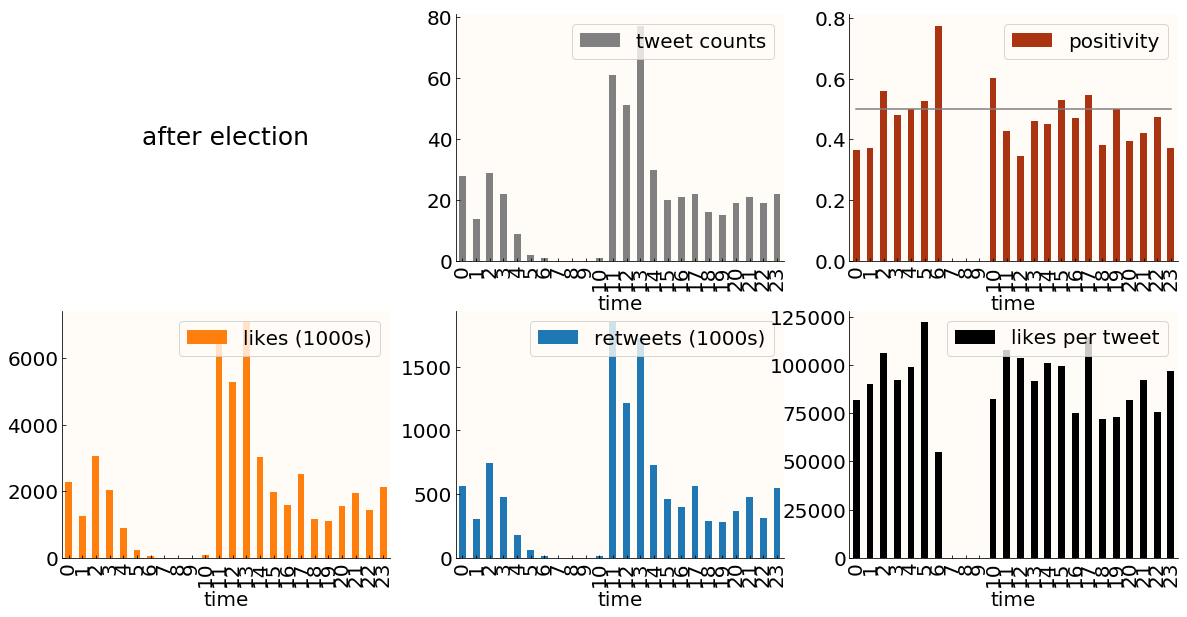

In [49]:
fig = pl.figure(figsize=(20, 10))
ax = fig.add_subplot(232)

df = pd.DataFrame({
    'time':
    ttimes[originalTweets * (ttimes >= electionNight)],
    'likes':
    liketweets[originalTweets * (ttimes >= electionNight)],
    'rts':
    retweets[originalTweets * (ttimes >= electionNight)],
    'prob':
    positiveprob[originalTweets * (ttimes >= electionNight)]
})

df1 = pd.DataFrame({})
df1['time'] = pd.date_range("0:00", "23:59", freq="60min")
df = df.merge(df1, how='outer')

df['UnixStamp'] = df['time'].apply(lambda d: time.mktime(d.timetuple()))
(df['likes'] * 1e-3).groupby(
    [df['time'].apply(lambda x: x.hour)]).count().plot(
        kind='bar', label="tweet counts", color='gray')
pl.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax0 = fig.add_subplot(233)
(df['prob']).groupby([df['time'].apply(lambda x: x.hour)]).mean().plot(
    kind='bar', label="positivity", color='#aa3311')
pl.plot([0, 23], [0.5, 0.5], 'gray')
pl.legend()
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax2 = fig.add_subplot(234)
(df['likes'] * 1e-3).groupby([df['time'].apply(lambda x: x.hour)]).sum().plot(
    kind='bar', label="likes (1000s)", color=lcolor)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

pl.legend()
ax3 = fig.add_subplot(235)
(df['rts'] * 1e-3).groupby([df['time'].apply(lambda x: x.hour)]).sum().plot(
    kind='bar', label="retweets (1000s)", color=rcolor)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
pl.legend()

ax4 = fig.add_subplot(236)
a = df['likes'].groupby([df['time'].apply(lambda x: x.hour)]).sum()
b = df['likes'].groupby([df['time'].apply(lambda x: x.hour)]).count()
(a / b).plot(kind='bar', label="likes per tweet", color='k')
pl.legend()
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

axlast = fig.add_subplot(231)
axlast.text(0.5, 0.5, "after election", fontsize=25, va='center', ha='center')
tmp = axlast.axis('off')

### Fig 13: Based on this we recommend DT to tweet in the early morning hours, cause he seems to be in a good mode right before his bad time, which appear to be 7-9AM (as I said, like many internet trolls). We recommends he avoids the evening hours, 5PM-2AM, when his likes-per-tweet are low. 

# On second thought though, our recommendation is to just stop tweeting altogether, cause it is intolerable to have to check twitter to see if he generated an international crisis, and since to be frank this analysis is pointless, contaminated as it is by robots, our only solid conclusions is that we elected an irrational internet troll to govern the largest power in the world.
